In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.dates import date2num
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import rasterio
from scipy.interpolate import griddata

# import geopandas as gpd

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib import pyplot as p

import cmocean # Beautiful colormaps for oceanography
import cmocean.cm as cmo
import os
import matplotlib.patheffects as path_effects

from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from netCDF4 import Dataset as NetCDFFile 

from obspy.imaging.beachball import beach

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from matplotlib.patches import Polygon

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

import shapefile as shp

from shapely.geometry import LineString, Point

# set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [175]:
# data = pd.read_csv('sum_with_2005_eqs.csv', header = 'infer')
data = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/SUeq_data.csv", header = 'infer')
# data.dtypes

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

In [176]:
# rupture outline
rup_2007 = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/rijsingen_eq/scraped/sum_rup/sum_sqk_02_rup.csv", skiprows=1)
rup_2005 = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/rijsingen_eq/scraped/sum_rup/sum_sqk_04_rup.csv", skiprows=1)
rup_2004 = pd.read_csv("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/rijsingen_eq/scraped/sum_rup/sum_sqk_05_rup.csv", skiprows=1)

In [177]:
# plate boundary data

sf = shp.Reader("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/PB2002_boundaries.shp")

In [178]:
# topography

# Define the GeoTIFF file path
topo = "/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/etopo-sunda.tiff"

# Open the GeoTIFF file using rasterio
with rasterio.open(topo) as src:
    # Read the topography data and extract the extent
    topography_data = src.read(1)  # Read the first band (adjust as needed)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

In [179]:
## Kuril kamchatka slab

slab_kk = NetCDFFile("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/SUslab_depth.grd")
# print(type(slab)) # print the type of the data 
# print(slab.variables.keys()) # print the variables in the data

lon_slab_kk = slab_kk.variables['x'][:]
lat_slab_kk = slab_kk.variables['y'][:]
depth_slab_kk = slab_kk.variables['z'][:]
depth_slab_kk = depth_slab_kk*-1

# creating meshgrid from our list of spatial coordinates
lon_slab_kk, lat_slab_kk = np.meshgrid(lon_slab_kk, lat_slab_kk)

In [180]:
import xarray as xr

## plate age

plate_age = xr.open_dataset("/Users/mohd0001/Research/PhD_Monash/Paper2/time-series/data/sum-age.grd")

lon = plate_age.variables['lon'][:]
lat = plate_age.variables['lat'][:]
age = plate_age.variables['z'][:]

## Map

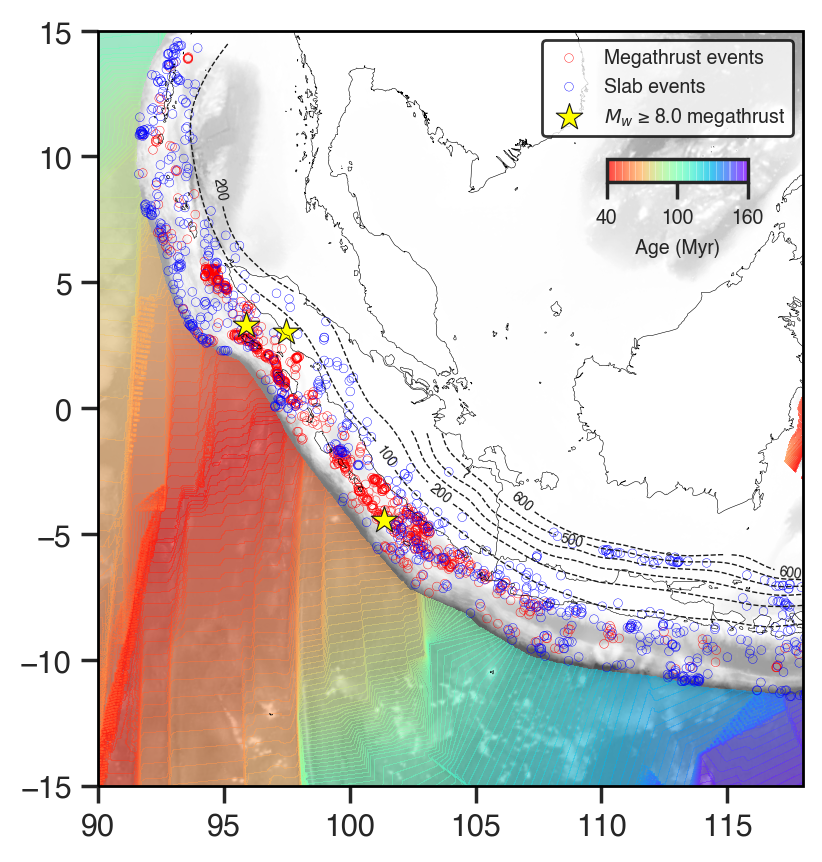

In [184]:
mag = 9
data_dw = data[(data['CLASS'] == 'DGOING') & (data['P(km)'] > 0)
               & (data['DEPTH'] > 0) & (data['MW'] <= mag)]
data_mthrust = data[(data['CLASS'] == 'MTHRUST') & (data['MW'] <= mag)]

fig, ax = plt.subplots(dpi = 200, figsize=(5,5))

fig1 = ax

projection = cartopy.crs.PlateCarree()
fig1 = plt.axes(projection = projection)

fig1.set_extent([90, 118, -15, 15])


# Plot the topography data

vmin, vmax = -8000, 0
fig1.imshow(topography_data, extent=extent, origin='upper',
            alpha = 0.8, cmap='Greys_r',
            vmin=vmin, vmax=vmax,
            transform=projection) # terrain

## plot slab contours
depth_levels=[0, 100, 200, 300, 400, 500, 600]
contour_kk = fig1.contour(lon_slab_kk, lat_slab_kk, depth_slab_kk, levels=depth_levels,
                       colors='k', linestyles='dashed', linewidths=0.5, transform=projection)
fig1.clabel(contour_kk, inline=True, fmt='%d', fontsize=5, colors='k', rightside_up=True)


# Create a contour plot of the plate age data
contour_levels = range(40, 161, 1)
contour = fig1.contourf(lon, lat, age, cmap='rainbow_r',
                        levels=contour_levels,
                        vmin = 40, vmax = 160, alpha=0.5)

cbaxes = inset_axes(fig1, width="20%", height="3%", loc=2,
                   bbox_to_anchor=(0.7,-0.15,1,1), bbox_transform=fig1.transAxes) 
cbar = plt.colorbar(contour, ax=fig1, ticks=[40, 100, 160], orientation='horizontal', cax=cbaxes)
size=7
cbar.set_label(label='Age (Myr)', size=size, weight='bold')
cbar.ax.tick_params(labelsize=size)

# Add coastlines without filled colors
fig1.add_feature(NaturalEarthFeature(
    category='physical', name='coastline', scale='10m',
    edgecolor='black', linewidth = 0.2, facecolor='none'  # Set facecolor to 'none'
))
    

# ## plot the plate boundary data
# for shape in sf.shapes():
#     x, y = zip(*shape.points)
#     fig1.plot(x, y, 'b-', linewidth=0.8, transform=projection)


###########

size = 10
fig1.scatter(data_mthrust['LON'], data_mthrust['LAT'], s=size, marker='o',
                 facecolor='none', edgecolor='red', linewidths = 0.15, alpha=1, label='Megathrust events')

fig1.scatter(data_dw['LON'], data_dw['LAT'], s=size, marker='o',
                 facecolor='none', edgecolor='blue', linewidths = 0.15, alpha=1, label='Slab events')


data_great = data[(data['CLASS'] == 'MTHRUST') & (data['MW'] >= 8)]

fig1.scatter(data_great['LON'], data_great['LAT'],
            marker = '*', s = 100, c = 'yellow', alpha = 1,
             edgecolor = 'k', linewidths = 0.4, label = '$M_w$ ≥ 8.0 megathrust') #label = '$M_w$ ≥ 8.8 Maule'


# fig1.plot(rup_2004['LON'], rup_2004['LAT'], '-', c = 'g', linewidth = 1.5, alpha=1)

# t1 = fig1.text(96, 8, '$M_w$ 9.0 (2004)', transform=ccrs.PlateCarree(), color='y',
#           fontsize=6, rotation=0, alpha=1,
#          path_effects = [path_effects.Stroke(linewidth=0.2, foreground='white'), path_effects.Normal()])



# # t1.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white', lw=0))

# # Draw a rectangular polygon
# # The coordinates are specified as (longitude, latitude) pairs
# rectangle_coords_sum = [(101.2, -11.4), (108, -3.2), (94.5, 15.5), (86, 14)]
# rectangle_coords_java = [(120, -14.1), (120, -5), (104, 1), (96.3, -6.2)]

# rect_sum = Polygon(rectangle_coords_sum, closed=True, edgecolor='red', facecolor='none', lw=1)
# fig1.add_patch(rect_sum)

# rect_java = Polygon(rectangle_coords_java, closed=True, edgecolor='blue', facecolor='none', lw=1)
# fig1.add_patch(rect_java)

# #  Create a legend for earthquake size and magnitude range
# # legend = fig1.legend(loc='upper left', title='Earthquake Magnitude', fontsize=10)
# # legend.set_title('Earthquake Magnitude', prop={'size': 12})

fontsize = 7
fig1.legend(loc = 'upper right',
            fontsize = fontsize,
            facecolor="white",
            edgecolor="black",
            markerscale=1)

# fig1.axvline(x=105, color='k', linestyle='--', lw=0.5, label='Latitude -6°')
# fig1.axhline(y=-6.5, color='k', linestyle='--', lw=0.5, label='Latitude -6°')

# fs = 15
# fig1.text(95, -3, 'A', ha='center', fontsize=fs)
# fig1.text(110, -3, 'B', ha='center', fontsize=fs)

# Manage latitude and longitude ticks
# Set the desired tick locations and labels
lat_ticks = [-15, -10, -5, 0, 5, 10, 15]
lon_ticks = [90, 95, 100, 105, 110, 115]

fig1.set_xticks(lon_ticks)
fig1.set_yticks(lat_ticks)

# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/sunda-age-map.jpg"
#             , dpi = 500, transparent= True, bbox_inches='tight')

In [182]:
# mag = 5
# data_dw = data[(data['CLASS'] == 'DGOING')
#                & (data['DEPTH'] > 0) & (data['MW'] <= mag)]
# data_mthrust = data[(data['CLASS'] == 'MTHRUST') & (data['MW'] <= mag)]



# figsize=(5,5)
# dpi = 250
# fig, ax = plt.subplots(dpi = dpi, figsize=figsize)

# fig1 = ax

# fig1.scatter(data_dw['LON'], data_dw['YEARS'],
#              marker = 'o', s = 20, facecolor = 'white',
#              edgecolor = 'blue', linewidths = 0.2, label = 'All Slab events ($M_w$ ≤ 5.0)')

# fig1.scatter(data_mthrust['LON'], data_mthrust['YEARS'],
#              marker = 'o', s = 10, facecolor = 'white',
#              edgecolor = 'red', linewidths = 0.3, label = 'Megathrust events ($M_w$ ≤ 5.1)')

# fig1.set_ylabel('Years from 2004 Sumatra EQ')
# # fig1.set_ylabel(r'$M_w$')
# fig1.set_xlabel(r'Longitude')

# data_great = data[(data['MW'] >= 9)]
# fig1.scatter(data_great['LON'], data_great['YEARS'],
#             marker = '*', s = 100, c = 'g', alpha = 1,
#              edgecolor = 'k', linewidths = 0.4, label = '$M_w$ ≥ 8.0')

# # Draw a vertical line at the location of the largest magnitude year
# fig1.axhline(y=0, color='g', lw=1, linestyle='--', label = '$M_w$ 9.2 Sumatra')


# # fs = 7
# # fig1.legend(loc = 'upper left',
# #             fontsize = fs,
# #             facecolor="white",
# #             framealpha=1,
# #             edgecolor="black",
# #             markerscale=1)

# # fig1.text(-20, 28, '$M_w$ ≤ 5.0 \n Depth > 0 km', ha='center', fontsize=fs)

# fig1.axvline(x=103, color='k', linestyle='--', lw=0.5)
# # fig1.axhline(y=-26, color='k', linestyle='--', lw=0.5)
# # fig1.axhline(y=-14, color='k', linestyle='--', lw=0.5)

# # fs = 12
# # fig1.text(-15, -20, 'A', ha='center', fontsize=fs)
# # fig1.text(-15, -32, 'B', ha='center', fontsize=fs)


# # fig1.set_ylim([-42, -12])

# # # tick location
# # lat_ticks = [-42, -32, -22, -12]
# # # lon_ticks = [-85, -80, -75, -70, -65, -60]

# # # fig1.set_xticks(lon_ticks)
# # fig1.set_yticks(lat_ticks)

# # plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/Japan-Lat-Years.jpeg"
# #             , dpi = 500, transparent= True, bbox_inches='tight')

## 3D slabs

In [183]:
# # Create a 3D figure
# fig = plt.figure(figsize=(10, 7), dpi=250)
# fig1 = fig.add_subplot(111, projection='3d')


# # Plot the subduction slabs using surface plots (or plot_wireframe for lines)
# izu_slab_surf = fig1.plot_surface(lon_slab_izu, lat_slab_izu, depth_slab_izu*-1,
#                                   edgecolor='none', color='r', alpha=0.8)
# japan_slab_surf = fig1.plot_surface(lon_slab_kk, lat_slab_kk, depth_slab_kk*-1,
#                                   edgecolor='none', color='r', alpha=0.8)
# ryu_slab_surf = fig1.plot_surface(lon_slab_ryu, lat_slab_ryu, depth_slab_ryu*-1,
#                                 edgecolor='none', color='g', alpha=0.8)

# # Customize the plot
# fig1.set_xlabel('Longitude')
# fig1.set_ylabel('Latitude')
# fig1.set_zlabel('Slab Depth (km)')
# # ax.set_title('3D Subduction of Slabs along the Trench')

# # Adjust the view angle for a better perspective
# fig1.view_init(elev=30, azim=140)  # Adjust the elevation and azimuth angles

# fig1.set_xlim(120, 160)
# fig1.set_ylim(20, 60)
# fig1.set_zlim(-600,0)

# # ## 2011 event
# # ax.scatter(mega_eq['LON'], mega_eq['LAT'], mega_eq['DEPTH']*-1,
# #              marker = '*', s = 300, c = color, alpha = 1,
# #              edgecolor = 'k', linewidths = 0.5)

# fig1.text(146, 40, 20, '$M_w$ 9.0 (2011)', color='k',
#           fontsize=8, rotation=0, alpha=1,
#          path_effects = [path_effects.Stroke(linewidth=0.1, foreground='white'), path_effects.Normal()])


# fontsize=10
# fig1.text(150, 40, -700, 'Pacific Plate', color='black',
#           fontsize=fontsize, rotation=0, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

# fig1.text(125, 38, -350, 'Philippines Plate', color='black',
#           fontsize=fontsize, rotation=0, alpha=alpha,
#          path_effects = [path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

# ## plot deep and shallow events as in the map

# # olive bands

# linewidth=0.5
# alpha = 1
# star=200
# circle=50

# fig1.scatter(data_mthrust_olive['LON'], data_mthrust_olive['LAT'], data_mthrust_olive['DEPTH']*-1,
#              marker = '*', s = star, c = 'olive', alpha = 0.7,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_olive['LON'], data_DW_olive['LAT'], data_DW_olive['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'olive', alpha = 0.7,
#              edgecolor = 'k', linewidths = linewidth)

# # orange bands

# fig1.scatter(data_mthrust_orange['LON'], data_mthrust_orange['LAT'], data_mthrust_orange['DEPTH']*-1,
#              marker = '*', s = star, c = 'orange', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_orange['LON'], data_DW_orange['LAT'], data_DW_orange['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'orange', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# # maroon bands


# fig1.scatter(data_mthrust_maroon['LON'], data_mthrust_maroon['LAT'], data_mthrust_maroon['DEPTH']*-1,
#              marker = '*', s = star, c = 'maroon', alpha = 0.7,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_maroon['LON'], data_DW_maroon['LAT'], data_DW_maroon['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'maroon', alpha = 0.7,
#              edgecolor = 'k', linewidths = linewidth)

# # purple bands

# fig1.scatter(data_mthrust_purple['LON'], data_mthrust_purple['LAT'], data_mthrust_purple['DEPTH']*-1,
#              marker = '*', s = star, c = 'purple', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_purple['LON'], data_DW_purple['LAT'], data_DW_purple['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'purple', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# # red bands


# fig1.scatter(data_mthrust_red['LON'], data_mthrust_red['LAT'], data_mthrust_red['DEPTH']*-1,
#              marker = '*', s = star, c = 'red', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_red['LON'], data_DW_red['LAT'], data_DW_red['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'red', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# # cyan bands

# fig1.scatter(data_mthrust_cyan['LON'], data_mthrust_cyan['LAT'], data_mthrust_cyan['DEPTH']*-1,
#              marker = '*', s = star, c = 'cyan', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_cyan['LON'], data_DW_cyan['LAT'], data_DW_cyan['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'cyan', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# # yellow bands


# fig1.scatter(data_mthrust_yellow['LON'], data_mthrust_yellow['LAT'], data_mthrust_yellow['DEPTH']*-1,
#              marker = '*', s = star, c = 'yellow', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_yellow['LON'], data_DW_yellow['LAT'], data_DW_yellow['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'yellow', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# # grey bands

# fig1.scatter(data_mthrust_grey['LON'], data_mthrust_grey['LAT'], data_mthrust_grey['DEPTH']*-1,
#              marker = '*', s = star, c = 'grey', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# fig1.scatter(data_DW_grey['LON'], data_DW_grey['LAT'], data_DW_grey['DEPTH']*-1,
#              marker = 'o', s = circle, c = 'grey', alpha = alpha,
#              edgecolor = 'k', linewidths = linewidth)

# ## rupture
# fig1.plot(rup_2011['LON'], rup_2011['LAT'], '-', c = 'grey', linewidth = 1.5, alpha=1)


# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/3D-Japan-Map.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')